In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Lambda, Dense, Flatten
from keras import backend as K 

from scipy import interpolate
import math

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [2]:
from helpers.composite_helpers import *

curtains_dir = "/global/home/users/rrmastandrea/CURTAINS_SALAD/"

n_features = 5
num_signal_to_inject = 2000
dataset_config_string = f"LHCO_{num_signal_to_inject}sig_f/"
STS_config_sting = f"LHCO_STS/"

exp_dir = os.path.join(curtains_dir, dataset_config_string)
data_dir = os.path.join(exp_dir, "data")

# load in the reverse rescales
path_to_minmax = "/global/home/users/rrmastandrea/CURTAINS_SALAD/LHCO_STS/data/col_minmax.npy"
col_minmax = np.load(path_to_minmax)

# dataset generation parameters
context_endpoints = (2500, 4500)


bands_dict = {"sb1": [2900, 3300],
              "sr" : [3300, 3700],
              "sb2": [3700, 4100]}

binning_scheme = np.linspace(-3.5, 3.5, 50)


"""
"""
"""
LOAD IN THE DATASETS AND PROCESS
"""
"""
"""

npull_dataset_train_sim = ToyDataset(data_dir, "train_sim.npy")
npull_dataset_val_sim = ToyDataset(data_dir, "val_sim.npy")
npull_dataset_train_dat = ToyDataset(data_dir, "train_dat.npy")
npull_dataset_val_dat = ToyDataset(data_dir, "val_dat.npy")
classif_train_sim = ToyDataset(data_dir, "classif_train_sim.npy")
classif_train_dat = ToyDataset(data_dir, "classif_train_dat.npy")

print("Num SIM events in SB:", len(npull_dataset_train_sim)+len(npull_dataset_val_sim))
print("Num DAT events in SB:", len(npull_dataset_train_dat)+len(npull_dataset_val_dat))
print()

# Preprocess the data
print("Preproccessing data...")
print()
dataset_train_sim = npull_dataset_train_sim.pull_from_mass_range([bands_dict["sb1"], bands_dict["sb2"]])
dataset_val_sim = npull_dataset_val_sim.pull_from_mass_range([bands_dict["sb1"], bands_dict["sb2"]])
dataset_train_dat = npull_dataset_train_dat.pull_from_mass_range([bands_dict["sb1"], bands_dict["sb2"]])
dataset_val_dat = npull_dataset_val_dat.pull_from_mass_range([bands_dict["sb1"], bands_dict["sb2"]])

dataset_sr_sim = classif_train_sim.pull_from_mass_range([bands_dict["sr"]])
dataset_sr_dat = classif_train_dat.pull_from_mass_range([bands_dict["sr"]])

dataset_train_sim = minmaxscale(dataset_train_sim.data, col_minmax, lower = -3, upper = 3, forward = True)
dataset_val_sim = minmaxscale(dataset_val_sim.data, col_minmax, lower = -3, upper = 3, forward = True)
dataset_train_dat = minmaxscale(dataset_train_dat.data, col_minmax, lower = -3, upper = 3, forward = True)
dataset_val_dat = minmaxscale(dataset_val_dat.data, col_minmax, lower = -3, upper = 3, forward = True)
dataset_sr_sim = minmaxscale(dataset_sr_sim.data, col_minmax, lower = -3, upper = 3, forward = True)
dataset_sr_dat = minmaxscale(dataset_sr_dat.data, col_minmax, lower = -3, upper = 3, forward = True)




Num SIM events in SB: 401354
Num DAT events in SB: 279186

Preproccessing data...



In [3]:
"""

ind = 4

plt.figure()

plt.hist(dataset_train_sim[:,ind])
plt.hist(dataset_train_dat[:,ind])
plt.show()
"""

'\n\nind = 4\n\nplt.figure()\n\nplt.hist(dataset_train_sim[:,ind])\nplt.hist(dataset_train_dat[:,ind])\nplt.show()\n'

# Actually train SALAD

In [4]:
#Next is SALAD


stored_weights = {}


def get_weights(data, model):
    yhat = model.predict(data, batch_size=128)
    return np.squeeze(yhat/(1 - yhat))


X_SALAD_sb_train = np.concatenate([dataset_train_sim, dataset_train_dat])
Y_SALAD_sb_train = np.concatenate([np.zeros(len(dataset_train_sim)), np.ones(len(dataset_train_dat))])

X_SALAD_val = np.concatenate([dataset_val_sim, dataset_val_dat])
Y_SALAD_val = np.concatenate([np.zeros(len(dataset_val_sim)),np.ones(len(dataset_val_dat))])

# testing set
X_SALAD_sr_train = np.concatenate([dataset_sr_sim, dataset_sr_dat])
Y_SALAD_sr_train = np.concatenate([np.zeros(len(dataset_sr_sim)), np.ones(len(dataset_sr_dat))])

X_SALAD_sb_train = X_SALAD_sb_train[:,:5]
X_SALAD_val = X_SALAD_val[:,:5]
X_SALAD_sr_train = X_SALAD_sr_train[:,:5]



print('Training...')

tf.keras.backend.clear_session()
model_SALAD_sb = Sequential()
model_SALAD_sb.add(Dense(64, input_dim=5, activation='relu')) 
model_SALAD_sb.add(Dense(64, activation='relu'))
model_SALAD_sb.add(Dense(64, activation='relu'))
model_SALAD_sb.add(Dense(1, activation='sigmoid'))
model_SALAD_sb.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

EPOCHS = 70

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint(f'{num_signal_to_inject}.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, epsilon=1e-7, mode='min')


hist_SALAD_sb = model_SALAD_sb.fit(
    X_SALAD_sb_train, Y_SALAD_sb_train, epochs=EPOCHS,
    batch_size=int(256), verbose=0, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_data=(X_SALAD_val, Y_SALAD_val)
)




print("done")


Training...

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
done


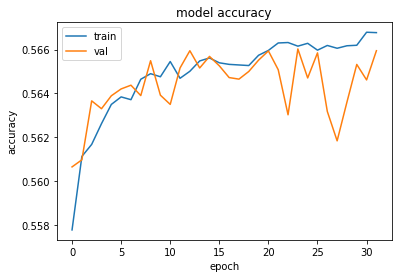

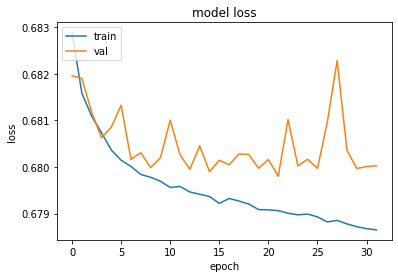

In [5]:

plt.plot(hist_SALAD_sb.history['accuracy'])
plt.plot(hist_SALAD_sb.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

     
plt.plot(hist_SALAD_sb.history['loss'])
plt.plot(hist_SALAD_sb.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [6]:
model_SALAD_sb.load_weights(f'{num_signal_to_inject}.mdl_wts.hdf5')
print("Evaluating at best val loss epoch:", np.argmin(hist_SALAD_sb.history['val_loss']))

# apply weight function
W_SALAD_sr_train = np.ones_like(Y_SALAD_sr_train)
W_SALAD_sr_train[Y_SALAD_sr_train == 0] = get_weights(X_SALAD_sr_train[Y_SALAD_sr_train == 0], 
                                                     model_SALAD_sb)


Evaluating at best val loss epoch: 21


# Final evaluation

In [7]:
#!/usr/bin/env python
# coding: utf-8

import torch
import os
from numba import cuda 

from helpers.composite_helpers import *


device = cuda.get_current_device()
device.reset()

# set the number of threads that pytorch will use
torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)


Using device: cuda


## Reprocess all the samples

In [8]:
X_SALAD_sr_train = minmaxscale(X_SALAD_sr_train, col_minmax, lower = -3, upper = 3, forward = False)
X_SALAD_sr_train = minmaxscale(X_SALAD_sr_train, col_minmax, lower = 0, upper = 1, forward = True)

"""
plt.figure()
plt.hist(X_SALAD_sr_train[:,0])
plt.show()
"""

'\nplt.figure()\nplt.hist(X_SALAD_sr_train[:,0])\nplt.show()\n'

In [9]:
def loc_analyze_band_transform(dir_to_save, idd, nn_train_data, nn_train_labs, class_weights, test_samp_1, test_samp_2, n_features, n_epochs, batch_size, lr, patience, device, update_epochs = 1, early_stop = True, visualize = True, seed = None):
    
    if seed is not None:
        #print(f"Using seed {seed}...")
        torch.manual_seed(seed)
        np.random.seed(seed)
            
    dense_net = NeuralNet(input_shape = n_features)
    criterion = F.binary_cross_entropy #nn.BCELoss()
    optimizer = torch.optim.Adam(dense_net.parameters(), lr=lr)

    dense_net.to(device)
    
    if early_stop:
        early_stopping = EarlyStopping(patience=patience)
    
        
    # train-test split
    val_size = 0.2
    
    # train-val split
    X_train, X_val, y_train, y_val = train_test_split(nn_train_data, nn_train_labs, test_size=val_size)
    

    nn_test_data = np.concatenate((test_samp_1, test_samp_2))
    nn_test_labs = np.concatenate((torch.zeros((test_samp_1.shape[0], 1)), torch.ones((test_samp_2.shape[0],1))))
    # shuffle the data
    nn_train_data, nn_train_labs = shuffle(nn_train_data, nn_train_labs)
    X_test, y_test = shuffle(nn_test_data, nn_test_labs)

    
    print("Train data, labels shape:", X_train.shape, y_train.shape)
    print("Val data, labels shape:", X_val.shape, y_val.shape)
    print("Test data, labels  shape:", X_test.shape, y_test.shape)
    
    for i in range(X_train.shape[1]):
        print(f"Feature {i} min, max for train: ({np.min(X_train[:,i])},{np.max(X_train[:,i])}), val: ({np.min(X_val[:,i])},{np.max(X_val[:,i])}), test: ({np.min(X_test[:,i])},{np.max(X_test[:,i])})")  
        
    # send to device
    X_train = np_to_torch(X_train, device)
    X_val = np_to_torch(X_val, device)
    X_test = np_to_torch(X_test, device)
    y_train = np_to_torch(y_train, device)
    y_val = np_to_torch(y_val, device)
    

    epochs, epochs_val = [], []
    losses, losses_val = [], []

    for epoch in tqdm(range(n_epochs)):
        # batching
        indices_list = torch.split( torch.randperm( X_train.shape[0] ), batch_size )
        # initialise lists to store batch stats
        losses_batch_per_e = []
        
        for i, indices in enumerate( indices_list ): # going through the batches
            # calculate the loss, backpropagate
            optimizer.zero_grad()
            
            batch_data = X_train[indices]
            batch_labels = y_train[indices]
            
            # get the weights
            batch_weights = (torch.ones(batch_labels.shape, device=device)
                        - batch_labels)*class_weights[0] \
                        + batch_labels*class_weights[1]

            
            loss = criterion(dense_net(batch_data), batch_labels, weight = batch_weights)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            losses_batch_per_e.append(loss.detach().cpu().numpy())

        epochs.append(epoch)
        losses.append(np.mean(losses_batch_per_e))
        
        # validation
        if epoch % update_epochs == 0:
            
            with torch.no_grad():
                # batching
                val_indices_list = torch.split( torch.randperm( X_val.shape[0] ), batch_size )
                # initialise lists to store batch stats
                val_losses_batch_per_e = []

                for i, indices in enumerate( val_indices_list ): # going through the batches
                    # calculate the loss, backpropagate
                    optimizer.zero_grad()
                    
                    batch_data = X_val[indices]
                    batch_labels = y_val[indices]

                    # get the weights
                    batch_weights = (torch.ones(batch_labels.shape, device=device)
                                - batch_labels)*class_weights[0] \
                                + batch_labels*class_weights[1]

                    
                    val_loss = criterion(dense_net(batch_data), batch_labels, weight = batch_weights) 

                    val_losses_batch_per_e.append(val_loss.detach().cpu().numpy())

            epochs_val.append(epoch)
            losses_val.append(np.mean(val_losses_batch_per_e))
            
            if early_stop:
                early_stopping(np.mean(val_losses_batch_per_e))
                
        if early_stopping.early_stop:
            break

    if visualize:
        fig, ax = plt.subplots(1, 1, figsize=(7, 5))
        ax.plot(epochs, losses)
        ax.plot(epochs_val, losses_val, label = "val")
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title(idd)
        fname = f"{dir_to_save}/losses_{idd}"
        fig.savefig(fname)

    # evaluate

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        outputs = dense_net(X_test).detach().cpu().numpy()
        predicted = np.round(outputs)

        # calculate auc 
        auc = roc_auc_score(y_test, outputs)
        fpr, tpr, _ = roc_curve(y_test, outputs)

    if visualize:
        fig, ax = plt.subplots(1, 1, figsize=(7, 5))
        ax.plot(fpr, tpr)
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_title("ROC: " + str(auc))
        fname = f"{dir_to_save}/roc_{idd}"
        fig.savefig(fname)
        
    np.save(f"{dir_to_save}/fpr_{idd}", fpr)
    np.save(f"{dir_to_save}/tpr_{idd}", tpr)
        
    if auc < 0.5:
        auc = 1.0 - auc
    
    return auc


In [10]:
epochs_NN =  100
batch_size_NN = 128
lr_NN = 0.001
patience_NN = 20


results_dir = f"/global/home/users/rrmastandrea/NF_results/nsig_inj{num_signal_to_inject}_seed1/"
os.makedirs(results_dir, exist_ok=True)


"""
"""
"""
STS DATA
"""
"""
"""

STS_dir = "/global/home/users/rrmastandrea/CURTAINS_SALAD/LHCO_STS/data/"

STS_bkg = ToyDataset(STS_dir, "STS_bkg.npy")
STS_sig = ToyDataset(STS_dir, "STS_sig.npy")



STS_bkg_dataset = STS_bkg.pull_from_mass_range([bands_dict["sr"]])
STS_sig_dataset = STS_sig.pull_from_mass_range([bands_dict["sr"]])

STS_bkg_dataset = minmaxscale(STS_bkg_dataset.data, col_minmax, lower = 0, upper = 1, forward = True)
STS_sig_dataset = minmaxscale(STS_sig_dataset.data, col_minmax, lower = 0, upper = 1, forward = True)




Y_SALAD_sr_train = Y_SALAD_sr_train.reshape(-1, 1)


"""
"""
"""
EVAL SALAD
"""
"""
"""


for seed_NN in range(0, 20, 1):
    

    print(f"On classifier seed {seed_NN}...")
    

    roc = loc_analyze_band_transform(results_dir, f"salad_{seed_NN}", 
                                     X_SALAD_sr_train, Y_SALAD_sr_train, W_SALAD_sr_train, STS_bkg_dataset[:,:-1], STS_sig_dataset[:,:-1], n_features, epochs_NN, batch_size_NN, lr_NN, patience_NN, device, visualize = True, seed = seed_NN)
    results_file = f"{results_dir}/salad_{seed_NN}.txt"

    with open(results_file, "w") as results:
        results.write(f"Discrim. power for STS bkg from STS sig in band SR: {roc}\n")
        results.write(3*"\n")

    print()
    print(20*"*")
    print()
        
        
   

On classifier seed 0...
Train data, labels shape: (195912, 5) (195912, 1)
Val data, labels shape: (48978, 5) (48978, 1)
Test data, labels  shape: (40000, 5) (40000, 1)
Feature 0 min, max for train: (0.0017086664835611982,0.8877576192220052), val: (0.0014009078343709307,0.9509881337483724), test: (0.005337465088814497,0.8737365007400513)
Feature 1 min, max for train: (1.3510386149088542e-06,0.8989002704620361), val: (5.245208740234375e-06,0.8752840360005697), test: (5.234752279648092e-06,0.7705807685852051)
Feature 2 min, max for train: (0.008307337760925293,0.9935704867045084), val: (-0.008684237798055014,0.9793432553609213), test: (0.018567243590950966,0.977394163608551)
Feature 3 min, max for train: (-0.004112919171651203,0.9969124794006348), val: (0.0004246234893798839,0.994470993677775), test: (0.0008824266260489821,0.9812214374542236)
Feature 4 min, max for train: (0.02644165356953931,0.8785417874654133), val: (0.058850248654683426,0.8729041417439779), test: (0.06629329919815063,0

 49%|████▉     | 49/100 [01:55<02:00,  2.36s/it]


KeyboardInterrupt: 